In [3]:
%matplotlib inline
import plotting_Boyle as plt_B
reload(plt_B)
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');
import sys 
sys.path.append('../code_general/')
from read_model_ID import unpack_parameters
import CRISPR_free_energy_landscape as FreeEnergy
reload(FreeEnergy);
import plotting_Boyle as plt_B
reload(plt_B)
import CRISPR_dCas9_binding_curve_Boyle as dCas9
reload(dCas9);

import analysis_SA_fits as SAfits
reload(SAfits);


# Check average landscape 

Given we essentially have ultimate freedom in some parts of the free-energy landscape, we decided to smoothen it by using the average result from multiple fits. 

However, the values of the rates are far less determined - they come out different every fit it seems. 
We know that in order to get a proper fit to the two-mismatch heatmap the solution satisfies: 
   1. $2\epsilon_I > \sum_{i=0}^{N} \epsilon_C[i]$
   2. The bound on-target's free-energy diagram is well determined: $F_n = -\log(\sum_{i=0}^{n} e^{-\epsilon_C[i]})$
   3. R-loop propagation is much faster than initiation of the R-loop. The on-target has a measurable/slow association rate, while seed mismatches are subjected to rejection events that are faster than detectable. What is kept constant is the total rate for the on-target - assuming R-loop initiation is rate limmiting allows us to only keep track of the propability of completing the R-loop - is kept fixed. Essentially, the system needs time to initiate the R-loop after which there is a probability to not (immediately) reject the substrate. If the R-loop gets completed, the protein is essentially so stabaly bound that we may ignore any further rejections.Hence, denoting Solution, PAM and R-loop by 'S', 'P', and 'R' and using an effective rate of $k_{PR} \times P_{n=1}$ - with $P_{n=1}$ the fixation probability of the BD-process starting from the first R-loop state - the effective rate to initiate and thereby complete R-loop becomes: 

    $$
    k_{OT} = \frac{k_{SP} k_{PR} P_{n=1}}{k_{SP} + k_{PS} + k_{PR}P_{n=1} }
    $$



   Assuming equillibrium between the PAM bound and unbound states ($k_{SP} + k_{PS} >> k_{RP}$):

   $$
   k_{OT} \approx \frac{k_{PR} P_{n=1}}{ 1 + K_{D}}
   $$ 
    with 
   $$ 
   K_{D} = \frac{k_{PS}}{k_{SP}} = e^{+\epsilon_{PAM}}
   $$

   Given an energy landscape, $K_D$ is fixed through $\epsilon_{PAM}$. Furthermore, assuming partial equillibration, $k_{SP}$ is irrelevant. We end up with two free parameters, the internal forward rate ($k_f$) and the rate into the R-loop from the PAM ($k_{PR}$) that will determine the value of $k_{init}$ - which is fixed by the association rate for the on-target. 
    Re-writing in terms of $k_{PR}$: 
   $$ 
   k_{PR} = k_{OT} (1 + K_D) (1 - \frac{ k_{OT}(1+ K_D)  e^{-\epsilon_1} }{ k_f P_{n=2}}   )^{-1}
   $$ 


   Our plan is to repeat the SA-optimisation multiple times and use the averaged energy landscape as our candidate. 
   Can we then find a value for the internal forward rate, such that the fit is still good? 
   Moreover, by sweeping the internal rate, we can find the bounds it must satisfy in order for the fit to be good enough.

## quickly check if $\chi^2$ of final solution is low enough (otherwise it did not manage to get good fit to single mismatch associaton rate) 

In [19]:
good_simulations = []
no_good = []
#[7,23,36,43,11,3]


Vtreshhold = 30000.

for sim in range(1,51):
    sa = pd.read_csv('../data/25_10_2018/fit_25_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    
    if (sa.Potential.iloc[-1] < Vtreshhold):
        good_simulations.append(sim)
    else:
        no_good.append(sim)

simset = []
for good_sim in good_simulations:
    filename = '../data/25_10_2018/fit_25_10_2018_sim_' +str(good_sim) +'.txt'
    simset.append(filename) 
    
    
    
    
set1 = range(7,10)
set2 = [11,14,15,16,17,19,20]
for sim in set1:
    sa = pd.read_csv('../data/19_10_2018/fit_19_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    
    if (sa.Potential.iloc[-1] < Vtreshhold):
        filename = '../data/19_10_2018/fit_19_10_2018_sim_' +str(sim) +'.txt'
        simset.append(filename)    
    else:
        no_good.append(sim)
    
    




In [20]:
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset)

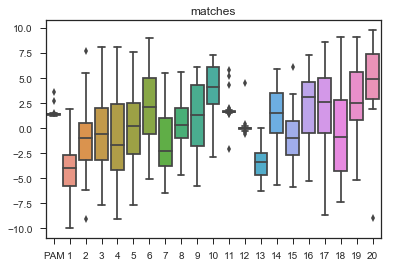

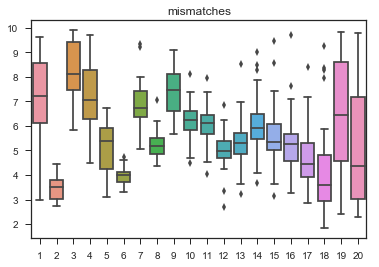

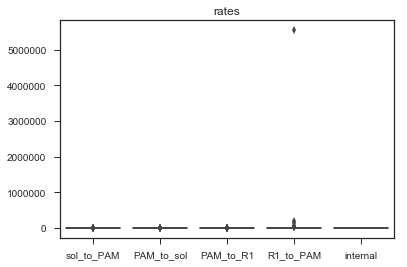

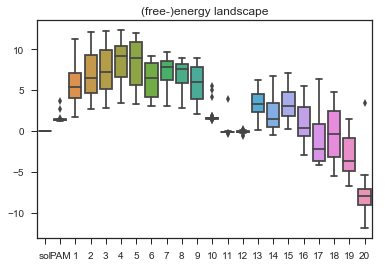

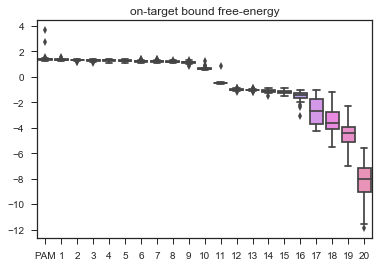

In [21]:
plt.figure()
sns.boxplot(data=matches)
plt.title('matches')

plt.figure()
sns.boxplot(data=mismatches)


plt.title('mismatches')

plt.figure()
sns.boxplot(data=rates)
plt.title('rates')

plt.figure()
sns.boxplot(data=landscape)
plt.title('(free-)energy landscape')

plt.figure()
sns.boxplot(data=free_energy)
plt.title('on-target bound free-energy')

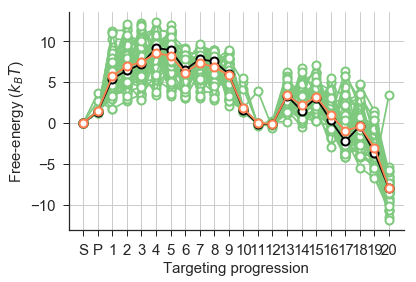

In [22]:
sns.set_palette('Accent')
model_id = 'init_limit_general_energies_v2'
Nparams = 44


for filename in simset:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    plt.plot(Energy_landscape,label=sim,color=sns.color_palette()[0],
            marker='o',
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2)

    

plt.xticks(range(0,21))
plt.grid();

LandscapeMED = landscape[landscape.columns[:]].median()
LandscapeMED.plot(color='black' , 
             marker='o',
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2);

LandscapeAVG = landscape[landscape.columns[:]].mean()
LandscapeAVG.plot(color='coral' , 
             marker='o',
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2);


plt.xlim(-1,22)
plt.xticks(range(0,22),['S','P']+list(LandscapeAVG.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('Free-energy ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine()

on target binding rate:  0.341860588725
optimum found at an internal rate of  300


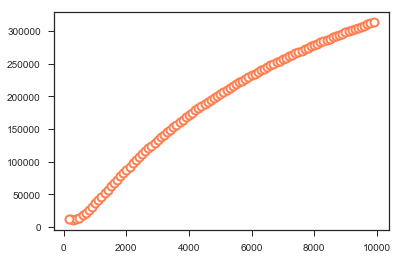

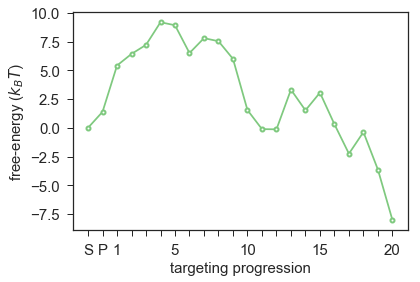

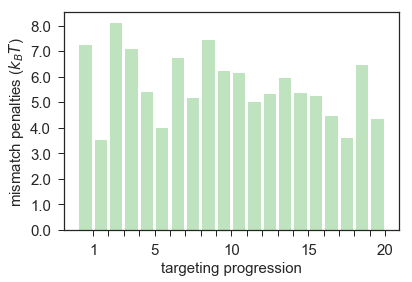

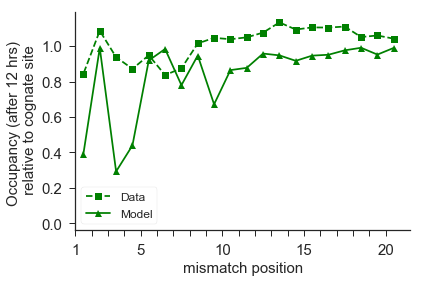

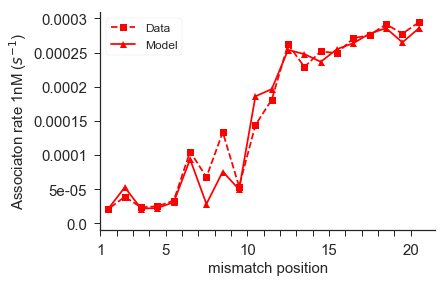

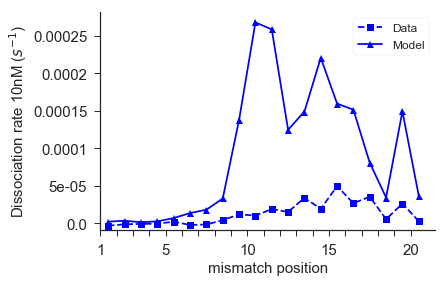

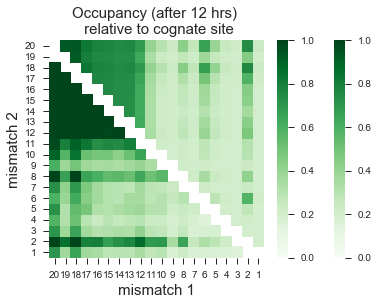

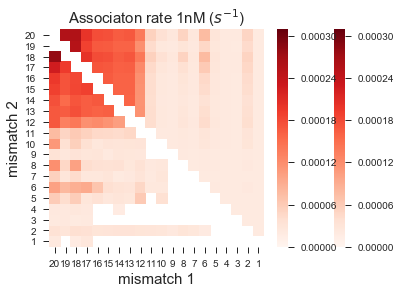

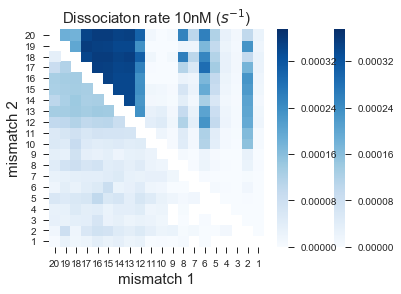

In [23]:
reload(SAfits);
reload(FreeEnergy);
mode = 'median'

if mode == 'mean':
    _, _, kOT = SAfits.average_solution(simset)
elif mode =='median':
    _, _, kOT = SAfits.median_solution(simset)
print 'on target binding rate: ', kOT * 1000 

forward_rates = [i*100 for i in range(2,100)] + [170]
V, kf_vals, kf_opt, parameters_opt, V_opt = SAfits.optimize_forward_rate(simset,forward_rates, mode=mode)


plt.plot(kf_vals,V, 
         linestyle='',
            color='coral' , 
                marker='o',
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2);
print 'optimum found at an internal rate of ', kf_opt



Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters_opt,model_id)


Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters_opt,model_id,
                                                                               show_plot=False);
# Energy_landscape_set1, FreeEnergy_landscape_set1 = FreeEnergy.plot_free_energy_landscape(parameters_set1,model_id,
#                                                                                         show_plot=False);
plt.figure()
plt.plot(range(-1,21),Energy_landscape,
        marker='o',
        markerfacecolor='white',
        markeredgewidth=2,
        markersize=4,
        )
# plt.plot(range(-1,21),Energy_landscape_set1,
#         marker='o',
#         markerfacecolor='white',
#         markeredgewidth=2,
#          markersize=4
#         )

plt.xlabel('targeting progression', fontsize=15)
plt.ylabel(r'free-energy ($k_BT$)',fontsize=15)
plt.xticks(range(-1,21),['S', 'P',1,'', '', '', 5, '', '', '', '', 10, '', '', '', '', 15, '', '', '', '', 20],
                    rotation=0,
                    fontsize=15);
plt.yticks(fontsize=15)


plt.figure()
FreeEnergy.plot_mismatch_penalties(parameters_opt, model_id)
# FreeEnergy.plot_mismatch_penalties(parameters_set1, model_id)

plt.figure()
plt_B.plot_single_mismatches(Model_pbound ,kind='Occupancy')

plt.figure()
plt_B.plot_single_mismatches(Model_on ,kind='OnRate')

# positions = 20 - np.arange(0,20)
# model= np.diag(Model_on_2)
# plt.plot(positions, model, linestyle='solid', marker='^', color='black', label='Model')

plt.figure()
plt_B.plot_single_mismatches(Model_off ,kind='OffRate')

plt.figure()
plt_B.plot_heatmap(Model_pbound ,kind='Occupancy')

plt.figure()
plt_B.plot_heatmap(Model_on ,kind='OnRate')

plt.figure()
plt_B.plot_heatmap(Model_off ,kind='OffRate')


# parameters_set1 = parameters_opt

In [13]:
print 10**parameters[-3]
print 10**parameters_opt[-3]

print 10**parameters[-2]
print 10**parameters_opt[-2]

print 10**parameters[-1]
print 10**parameters_opt[-1]

3.88829332981
1000.0
0.0205159179468
0.020603053459
808.418035395
800.0


In [62]:
parameters_opt

array([ 1.34975563, -3.70239415, -3.05166036,  3.21055492, -4.72258911,
       -1.17020243,  7.42004207, -5.57428039,  0.4097269 ,  2.81808723,
        4.1868514 ,  1.59630753,  0.05890752, -2.03496539, -3.40716557,
        3.36692327, -3.00389665,  8.65283548, -3.78089074,  4.87567009,
        2.46424231,  6.64381913,  3.85901412,  7.98663318,  7.78425271,
        4.33836083,  3.83547373,  6.45189767,  5.06453358,  7.81751516,
        5.94629588,  5.85776958,  4.8298259 ,  5.07249001,  5.70037242,
        4.98560464,  4.53603745,  3.8837022 ,  3.37008732,  6.54068605,
        8.36411422,  0.58975898, -1.8255581 ,  2.90763599])

In [60]:
rates

,sol_to_PAM,PAM_to_sol,PAM_to_R1,R1_to_PAM,internal
sim,,,,,
../data/25_10_2018/fit_25_10_2018_sim_1.txt,3.888293,14.995137,0.020516,0.831803,808.418035


In [44]:
fast_Rloop

,kinetic,thermodynamic
sim,,
../data/25_10_2018/fit_25_10_2018_sim_1.txt,0.338916,0.339212


In [36]:
_,k,_ = dCas9.calc_Boyle(CalcOccupancy=False, CalcOffRate=False, CalcOnRate=True,
                parameters=parameters_opt, mismatch_positions=[], guide_length=20, 
                 model_id=model_id)
print 1000*k 

0.356700248665
400000


In [22]:
0.342049792299, V_opt

(0.342049792299, 20546.217777003338)

In [37]:
parameters_opt

array([ 1.38547217, -3.88267749, -1.39311104, -1.21188436, -1.02604773,
        0.33590016,  2.0646203 , -1.22574656,  0.38299192,  1.64380501,
        4.15371179,  1.65003326,  0.02194017, -3.70622142,  2.25734209,
       -1.44500028,  2.35893005,  2.66327885, -1.60585446,  2.98558456,
        4.37639224,  7.22808118,  3.45678989,  8.50537273,  6.85114789,
        5.39871   ,  3.98987781,  6.66319015,  5.20692277,  7.48441548,
        6.24828932,  6.14902761,  5.06521455,  5.31111367,  6.04588732,
        5.43044567,  5.33181771,  4.446801  ,  3.5876303 ,  6.7515533 ,
        4.35871925,  3.        , -1.60994622,  2.60205999])

# Compare to Finkelstein lab data 

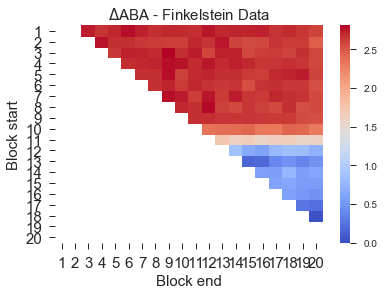

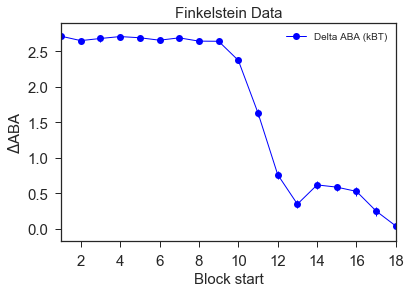

In [90]:
sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA
reload(pltABA);


IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

BlockMismatches, _,ABA_first_mm_pos = pltABA.plot_block_mm_ABA(IlyaData, 
                                                               SaveFigures=True,
                                                               figure_names=['../reports/fig41_10_10_2018.pdf',
                                                                            '../reports/fig42_10_10_2018.pdf']);

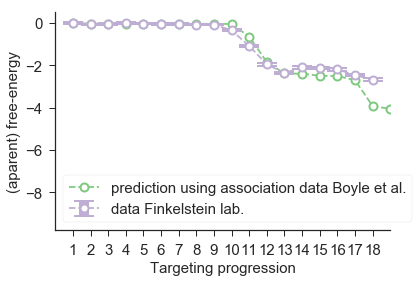

In [94]:
ABA_landscape = ABA_first_mm_pos['Delta ABA (kBT)'] - ABA_first_mm_pos['Delta ABA (kBT)'][0]
FreeEnergy_landscape_shifted = FreeEnergy_landscape - FreeEnergy_landscape[0]


plt.plot(range(1,len(FreeEnergy_landscape_shifted)+1),FreeEnergy_landscape_shifted,
        marker='o',
        markersize=8,
        markerfacecolor='white',
        markeredgewidth=2,
        linestyle='dashed',
        label='prediction using association data Boyle et al.')
plt.errorbar(range(1,len(ABA_landscape)+1),ABA_landscape,
        yerr=np.array(ABA_first_mm_pos['Uncertainty']),
        elinewidth=10,
        capsize=10,
        marker='o',
        markersize=8,
        markerfacecolor='white',
        markeredgewidth=2,
        linestyle='dashed',
        label='data Finkelstein lab.')
plt.xlim(0,19);
# plt.ylim(-4.0,0.0);
plt.xticks(range(1,19),fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('(aparent) free-energy',fontsize=15)
plt.legend(loc='best',frameon=True,fontsize=15);
sns.despine();

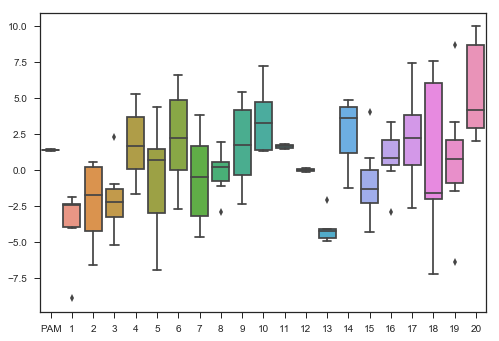

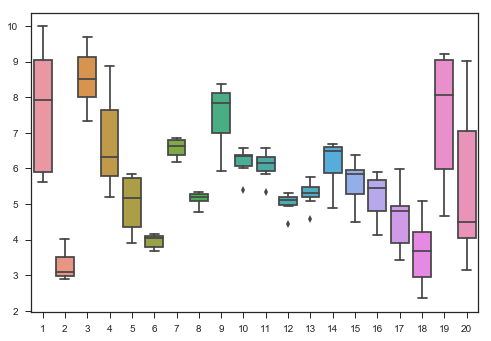

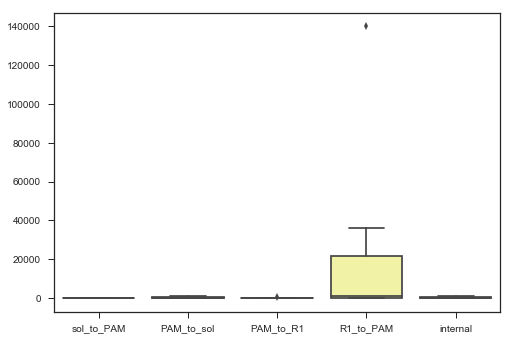

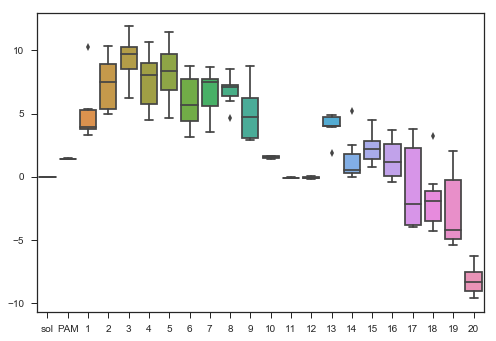

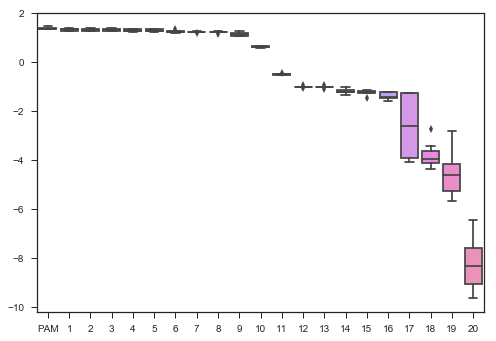

In [109]:
plt.figure()
sns.boxplot(data=matches)

plt.figure()
sns.boxplot(data=mismatches)

plt.figure()
sns.boxplot(data=rates)

plt.figure()
sns.boxplot(data=landscape)

plt.figure()
sns.boxplot(data=free_energy)

In [34]:



kOT = calc_on_rate()




LandscapeAVG = landscape[landscape.columns[:]].mean()

In [50]:
from scipy import optimize
import Boyle_data_processing as Bdata
reload(Bdata);

import CRISPR_dCas9_binding_curve_Boyle as dCas9
reload(dCas9);














In [61]:
xdata

NameError: name 'xdata' is not defined

In [3]:
reload(plt_B)
reload(FreeEnergy)

sys.path.append('../code_Pclv /')
import CRISPR_Kinetic_model as Pclv 
reload(Pclv);

model_id = 'init_limit_general_energies_v2'
Nparams = 44
set1 = range(4,10)
set2 = [11,14,15,16,17,19,20]
set3 = [21,22,23]
column_names = ['sim','PAM']
for n in range(1,21):
    column_names.append(str(n))


    
    

match_rows = []
mismatch_rows = []
rates_rows = []
landscape_rows = []
FreeEnergy_rows = []


rate_to_cleave = 10**9 
fast_Rloop_rows = []

for sim in set1+set2: 
    filename = '../data/19_10_2018/fit_19_10_2018_sim_' + str(sim) + '.txt'
    
    if sim in set3:
        model_id = 'general_energies_v2'
        Nparams = 43
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    epsilon,fwd_rates = unpack_parameters(parameters, model_id)
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    
    
    match_data = {}
    match_data['sim'] = sim 
    for i,key in enumerate(column_names[1:]):
        match_data[key] = epsilon[i] 
    match_rows.append(match_data)
     
    mismatch_data = {}
    mismatch_data['sim'] = sim
    for i, key in enumerate(column_names[2:]):
        mismatch_data[key] = epsilon[21+i]
    mismatch_rows.append(mismatch_data)
    
    rates_data = {}
    
    rates_data['sim'] = sim
    rates_data['R1_to_PAM'] = fwd_rates[1] * np.exp(-epsilon[1])
    rates_data['PAM_to_sol'] = fwd_rates[0] * np.exp(epsilon[0])
    for i, key in enumerate(['sol_to_PAM','PAM_to_R1','internal']):
        rates_data[key] = fwd_rates[i]
    rates_rows.append(rates_data)
    
    landscape_data = {}
    landscape_data['sim'] = sim 
    for i, key in enumerate(['sol']+column_names[1:]):
        landscape_data[key] = Energy_landscape[i]
    landscape_rows.append(landscape_data)
    
    FreeEnergy_data = {}
    FreeEnergy_data['sim'] = sim 
    for i, key in enumerate(column_names[1:]):
        FreeEnergy_data[key] = FreeEnergy_landscape[i]
    FreeEnergy_rows.append(FreeEnergy_data)
    
    
    
    
    Delta = Pclv.translate_binding_to_cleaving(parameters, model_id, rate_to_cleave, mismatch_positions=[])
#     Delta = np.diff(LandscapeAVG)

    P = Pclv.Pclv(Delta[1:]) 
    kPR = fwd_rates[1] * P
    kSP = 0.1*fwd_rates[0]
    kPS = kSP*np.exp(epsilon[0]+np.log(10.0))
    k_init = kPR * kSP  / (kPR  + kSP + kPS)
    
#     print P , kPR 
    kinetic = k_init * 1000
    thermodynamic = kPR /(1.0 + np.exp(+epsilon[0]+np.log(10.0))) *1000
    
    fast_Rloop_data = {}
    fast_Rloop_data['sim'] = sim
    fast_Rloop_data['kinetic'] = kinetic
    fast_Rloop_data['thermodynamic'] = thermodynamic
    
    fast_Rloop_rows.append(fast_Rloop_data)

    
matches = pd.DataFrame(match_rows, columns = column_names )
mismatches = pd.DataFrame(mismatch_rows, columns = ['sim']+[str(i) for i in range(1,21) ])
rates = pd.DataFrame(rates_rows, columns=['sim','sol_to_PAM','PAM_to_sol','PAM_to_R1','R1_to_PAM','internal'])
landscape = pd.DataFrame(landscape_rows,columns=['sim','sol'] + column_names[1:])
free_energy = pd.DataFrame(FreeEnergy_rows, columns= column_names)

fast_Rloop = pd.DataFrame(fast_Rloop_rows, columns= ['sim','kinetic','thermodynamic'])

matches.set_index('sim',inplace=True)
mismatches.set_index('sim',inplace=True)
rates.set_index('sim',inplace=True)
landscape.set_index('sim',inplace=True)
free_energy.set_index('sim',inplace=True)

fast_Rloop.set_index('sim',inplace=True)


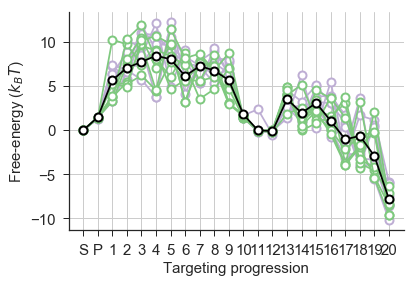

In [171]:
reload(plt_B)
reload(FreeEnergy)


sns.set_palette('Accent')
model_id = 'init_limit_general_energies_v2'
Nparams = 44

set1 = range(4,10)
set2 = [11,14,15,16,17,19,20]
set3 = [21,22,23]

# set1 = [11,16,19,20]
# set2 = [14,15,17]

for sim in set1:
    filename = '../data/19_10_2018/fit_19_10_2018_sim_' + str(sim) + '.txt'
    parameters = plt_B.load_simm_anneal(filename, Nparams)
#     Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters,model_id)
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    plt.plot(Energy_landscape,label=sim,color=sns.color_palette()[1],
            marker='o',
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2)

for sim in set2:
    filename = '../data/19_10_2018/fit_19_10_2018_sim_' + str(sim) + '.txt'
    parameters = plt_B.load_simm_anneal(filename, Nparams)
#     Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters,model_id)
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    plt.plot(Energy_landscape,label=sim,color=sns.color_palette()[0],
            marker='o',
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2)
    

# plt.legend();
plt.xticks(range(0,21))
plt.grid();


LandscapeAVG = landscape[landscape.columns[:]].mean()
FreeEnergyAVG =  -1*np.log( np.cumsum( np.exp(-LandscapeAVG[1:])   )  )


# LandscapeMAX = landscape[landscape.columns[:-1]].max()
# FreeEnergyMAX =  -1*np.log( np.cumsum( np.exp(-LandscapeMAX[1:])   )  )



LandscapeAVG.plot(color='black' , 
                            marker='o',
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2);




plt.xlim(-1,22)
plt.xticks(range(0,22),['S','P']+list(LandscapeAVG.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('Free-energy ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine()

We figured that all times to transition between internal (R-loop) states are irrelevant for the cognate site and (maybe) for sites that have a single mismatch. 
Essentially, the system needs time to initiate the R-loop after which there is a probability to not (immediately) reject the substrate. If the R-loop gets completed, the protein is essentially so stabaly bound that we may ignore any further rejections.
Hence, using an effective rate of $k_{PR} \times P_{n=1}$ - with $P_{n=1}$ the fixation probability of the BD-process starting from the first R-loop state - the effective rate to initiate and thereby complete R-loop becomes: 

$$
k_{init} = \frac{k_{SP} k_{PR} P_{n=1}}{k_{SP} + k_{PS} + k_{PR}P_{n=1} }
$$



Assuming equillibrium between the PAM bound and unbound states ($k_{SP} + k_{PS} >> k_{RP}$):

$$
k_{init} \approx \frac{k_{PR} P_{n=1}}{ 1 + K_{D}}
$$ 
with 
$$ 
K_{D} = \frac{k_{PS}}{k_{SP}} = e^{-\epsilon_{PAM}}
$$

Given an energy landscape, $K_D$ is fixed. Furthermore, assuming partial equillibration, $k_{SP}$ is irrelevant. We end up with two free parameters, the internal forward rate ($k_f$) and the rate into the R-loop from the PAM ($k_{RP}$) that will determine the value of $k_{init}$ - which is fixed by the association rate for the on-target. 
Re-writing in terms of $k_{RP}$: 
$$ 
k_{RP} = k_{init} (1 + K_D) (1 - \frac{ k_{init}(1+ K_D)  e^{-\epsilon_1} }{ k_f P_{n=2}}   )^{-1}
$$ 


Our plan is to repeat the SA-optimisation multiple times and use the averaged energy landscape as out candidate. 
Can we then find a value for the internal forward rate, such that the fit is still good? 
Moreover, by sweeping the internal rate, we can find the bounds it must satisfy in order for the fit to be good enough.

In [15]:
print Kd , kf , 10**parameters[-1], 10**parameters[-2], 10**parameters[-3]
print Kd , kf , 10**new_parameters[-1], 10**new_parameters[-2], 10**new_parameters[-3]

3.77291569838 612.161209132 612.161209132 0.0175677842576 426.080090706
3.77291569838 612.161209132 612.161209132 6.29803968721e-05 426.080090706


In [20]:
rates 

,sol_to_PAM,PAM_to_sol,PAM_to_R1,R1_to_PAM,internal
sim,,,,,
4,35.765189,159.831791,693.899619,4012.048492,844.810683
5,0.280739,1.026352,6.271130,1016.270985,794.375141
6,447.784639,1675.532287,265.459248,107387.791594,415.154626
7,0.104450,0.387302,0.027052,12.179620,646.905133
8,0.700941,2.784868,1.872700,13.499503,652.728232
9,426.080091,1607.564263,0.017568,2.583526,612.161209
11,0.848745,3.340318,19.198275,139789.758276,218.958062
14,68.381349,278.284653,0.973952,9.995091,82.378850
15,289.566781,1130.940527,28.166334,308.523084,679.238968


In [7]:
fast_Rloop

,kinetic,thermodynamic
sim,,
4,0.325917,0.325947
5,0.349844,0.354258
6,0.333671,0.333674
7,0.327897,0.338524
8,0.328526,0.330073
9,0.337257,0.337260
11,0.337406,0.338753
14,0.328900,0.328916
15,0.341868,0.341872


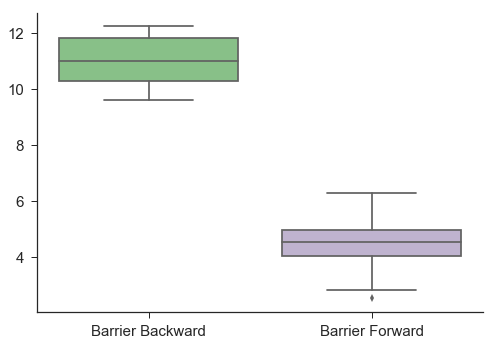

In [83]:
def calc_left_barrier(row):
    return np.max(row[landscape.columns[1:14]])

def calc_right_barrier(row):
    return np.max(row[landscape.columns[14:22]])



landscape['Barrier Backward'] = landscape.apply(calc_left_barrier, axis=1)
landscape['Barrier Forward'] = landscape.apply(calc_right_barrier,axis=1)

sns.boxplot(data=landscape[['Barrier Backward', 'Barrier Forward']])
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
sns.despine();

In [66]:
epsilon, fwd_rates = unpack_parameters(parameters,model_id)

In [73]:
epsilon[:21]

array([ 1.3746941 , -3.86301338,  0.30782913, -5.23022926, -0.51462663,
        0.92512582,  6.5805241 , -4.44610524,  0.38886525,  1.76939028,
        3.87421379,  1.72112099, -0.09926783, -4.56635645,  4.02731136,
       -1.65111896,  2.57996256,  3.5689452 , -7.22801711,  8.67968028,
        4.18604113])

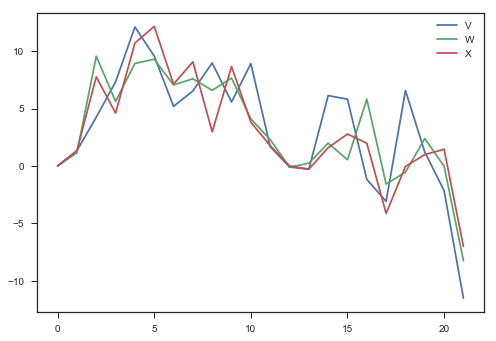

In [2]:
reload(plt_B)
reload(FreeEnergy)

model_id = 'init_limit_general_energies_v2'
filename = '../data/13_9_2018/fit_13_9_2018_sim_X.txt'
Nparams = 44


# parameters[:21] = 0.0



for sim in ['V','W','X']:
    filename = '../data/13_9_2018/fit_13_9_2018_sim_' + sim + '.txt'
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters,model_id)
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    plt.plot(Energy_landscape,label=sim)
    
plt.legend();
# plt.savefig('../reports/fig40_10_10_2018.pdf',format='pdf',bbox_inches='tight');


# plt.figure()
# FreeEnergy.plot_mismatch_penalties(parameters, model_id)




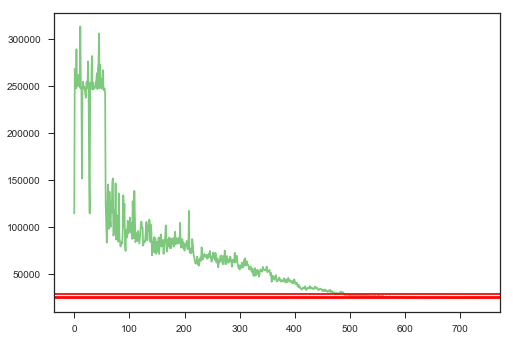

In [8]:
def deviation_from_mean(x):
    return np.abs(x - np.mean(x))/ np.abs(np.mean(x))



model_id = 'init_limit_general_energies_v2'
filename = '../data/13_9_2018/fit_13_9_2018_sim_X.txt'
Nparams = 44

sa = pd.read_csv(filename, delimiter='\t', index_col=Nparams+2)

chi_squared = np.array(sa.Potential)

# select solutions that fall within these bounds: 
confidence = 95 
perctentile_val = (100 - confidence)*0.5
avg = np.mean(chi_squared[-250:])
conf_low = np.percentile(chi_squared[-250:],perctentile_val)
conf_high= np.percentile(chi_squared[-250:],100 - perctentile_val )

plt.plot(chi_squared[:])
plt.axhline(avg,color='red')
plt.axhline(conf_low,color='red')
plt.axhline(conf_high,color='red')


selected_solutions = sa[(sa.Potential>=conf_low) & (sa.Potential<=conf_high)]
for param in range(Nparams-2,Nparams+1):
    key = 'Parameter ' + str(param)
#     selected_solutions[key] = deviation_from_mean(selected_solutions[key])
#     plt.scatter(x=[param]*len(selected_solutions), y=selected_solutions[key])
    

    
    
    
# plt.scatter(selected_solutions['Parameter 44'],selected_solutions['Potential'])
# np.corrcoef(x=selected_solutions['Parameter 44'],y=selected_solutions['Potential'])

In [6]:
selected_solutions

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,...,Parameter 37,Parameter 38,Parameter 39,Parameter 40,Parameter 41,Parameter 42,Parameter 43,Parameter 44,Potential,Equilibruim
NaN,1.385483,-8.958040,7.307266,-5.134278,-3.806974,2.732247,-0.572996,7.432475,-4.282007,3.282825,...,6.470448,7.618868,8.975725,5.882620,3.543422,0.159212,0.194755,2.911850,28737.741338,True
NaN,1.326095,-6.759539,4.016422,-3.828351,-4.466896,3.986299,-1.055611,5.928876,-3.423558,3.493267,...,6.188525,7.981203,9.670645,4.284288,3.561300,-0.341666,1.569923,2.932995,28324.179892,True
NaN,1.345300,-6.429070,3.885192,-3.938442,-4.622806,3.770764,-1.246539,5.753621,-3.620453,4.224167,...,5.843069,7.676821,9.328959,4.833932,3.155367,-0.898233,2.480686,2.954027,28858.934250,True
NaN,1.327185,-6.498220,3.737867,-3.836409,-4.457852,4.269394,-1.465928,5.694575,-3.887362,4.143187,...,6.350621,7.487418,9.218107,4.543643,3.666730,-0.837542,2.930006,2.937132,28506.134301,True
NaN,1.296835,-6.443982,3.545575,-3.771779,-4.177606,4.527884,-1.740696,5.850713,-3.993261,3.794724,...,6.217172,7.192515,9.013280,5.407386,3.308539,-0.850127,2.640277,2.818281,28129.210460,True
NaN,1.283808,-5.970316,3.670392,-3.610306,-5.058899,5.213811,-2.843944,5.515909,-3.441586,3.534692,...,5.048618,6.564575,9.853644,6.172775,2.998649,0.664446,2.793225,2.884061,28416.736898,True
NaN,1.390334,-5.835846,4.098845,-3.906239,-5.173665,5.142823,-2.948540,6.120124,-3.395132,3.443957,...,5.015508,6.859088,9.962215,6.296101,3.332446,1.237778,2.598689,2.881283,28354.265295,True
NaN,1.243285,-5.666775,3.089345,-3.894847,-4.634384,5.268534,-2.519539,5.726128,-3.548686,2.997383,...,4.886528,6.120045,9.797012,6.728505,3.832070,0.621400,2.511932,2.926783,28188.328151,True
NaN,1.362392,-5.411110,2.913848,-4.312003,-4.045708,5.433968,-2.259951,5.533282,-3.836115,2.900142,...,5.173859,6.195842,9.643769,6.686362,3.993417,0.805366,2.708170,2.836797,26951.597126,True
NaN,1.328704,-5.548554,2.843962,-3.870931,-4.030020,5.653560,-2.203153,5.652479,-4.221638,2.554121,...,5.713212,6.186064,9.846392,7.078019,3.739137,0.541735,2.858585,2.701644,28167.032559,True


/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


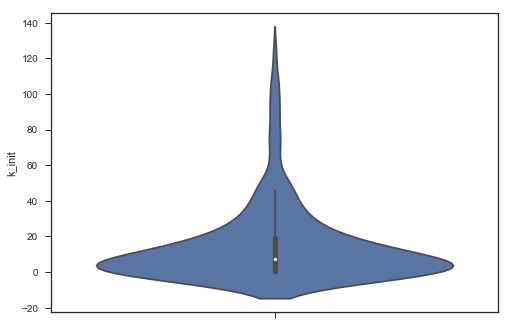

In [122]:
kb = np.exp(selected_solutions['Parameter 1']) * 10**selected_solutions['Parameter 42']
kf = 10**selected_solutions['Parameter 42']
khat = 10**selected_solutions['Parameter 43']


k_init = khat * kf / (khat  + kf + kb)
selected_solutions['k_init'] = k_init 

sns.violinplot(y=selected_solutions['k_init'])

In [124]:
np.median(k_init)

7.0983129898517063

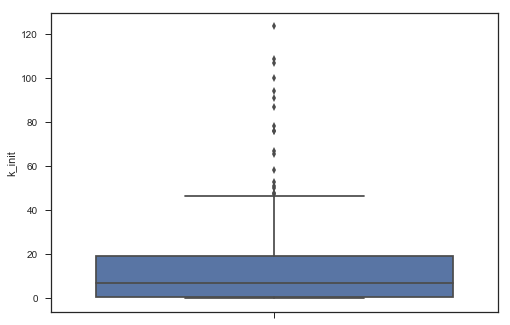

In [125]:
sns.boxplot(y=selected_solutions['k_init'])

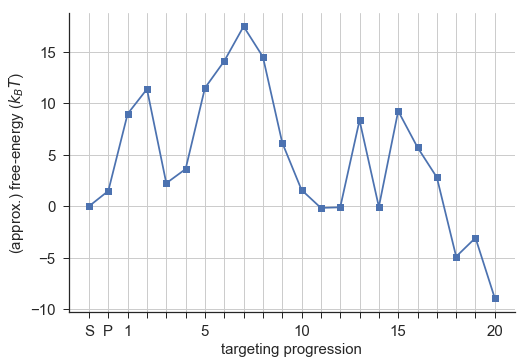

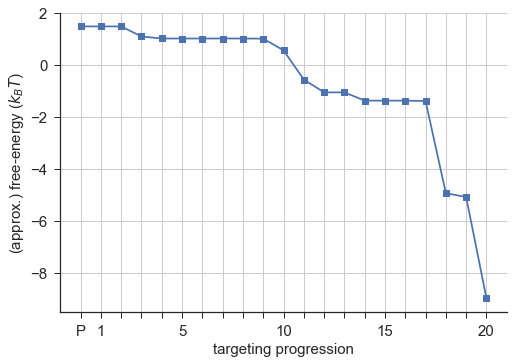

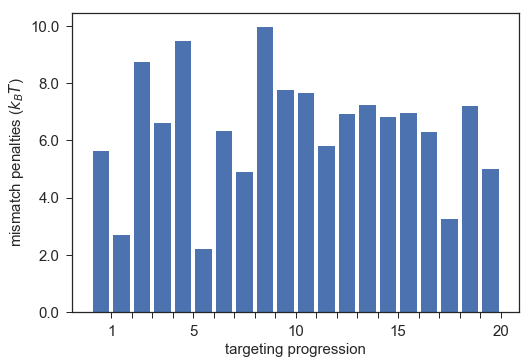

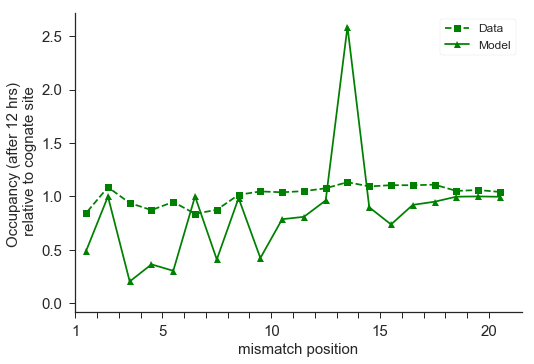

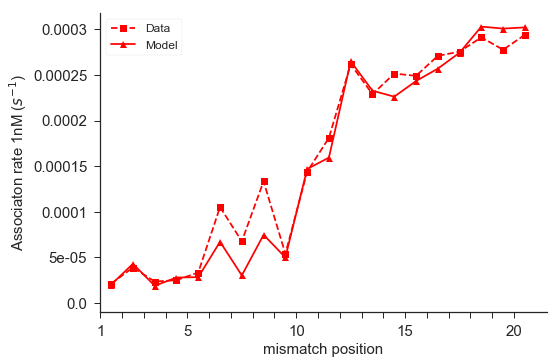

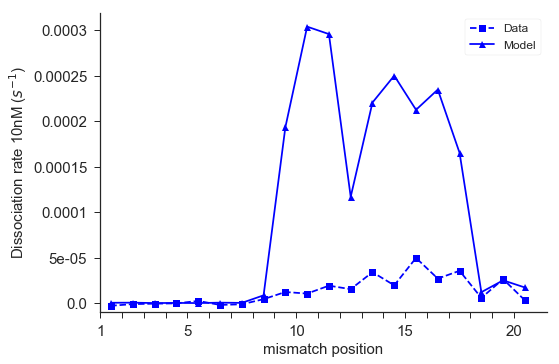

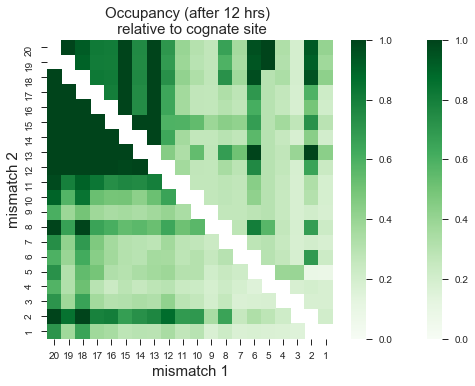

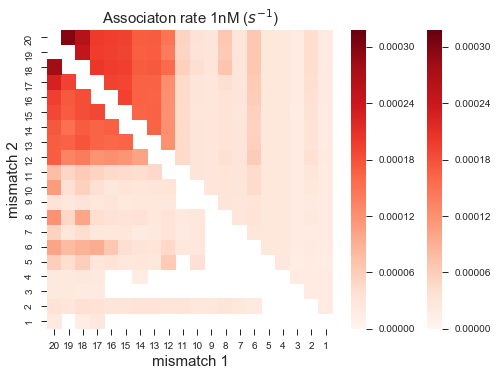

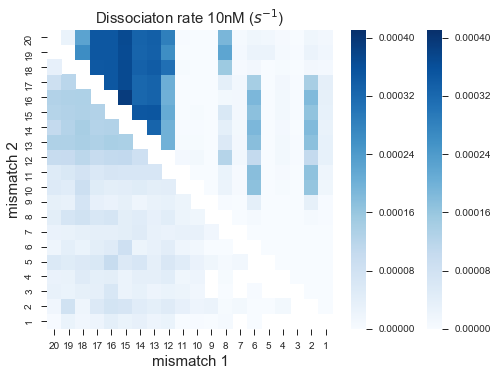

In [2]:
reload(plt_B)
reload(FreeEnergy)

model_id = 'init_limit_general_energies_v2'
filename = '../data/13_9_2018/fit_13_9_2018_sim_O.txt'
Nparams = 44
parameters = plt_B.load_simm_anneal(filename, Nparams)

Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters,model_id)

# Energy_landscape = FreeEnergy.plot_landscape(parameters, model_id)
Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id);

plt.figure()
FreeEnergy.plot_mismatch_penalties(parameters, model_id)

plt.figure()
plt_B.plot_single_mismatches(Model_pbound ,kind='Occupancy')

plt.figure()
plt_B.plot_single_mismatches(Model_on ,kind='OnRate')

plt.figure()
plt_B.plot_single_mismatches(Model_off ,kind='OffRate')

plt.figure()
plt_B.plot_heatmap(Model_pbound ,kind='Occupancy')

plt.figure()
plt_B.plot_heatmap(Model_on ,kind='OnRate')

plt.figure()
plt_B.plot_heatmap(Model_off ,kind='OffRate')
